In [138]:
from typing import *
import torch
from torch import nn
from torchtyping import TensorType, patch_typeguard
from transformer import Transformer
import matplotlib.pyplot as plt
from dataclasses import dataclass, field

%load_ext autoreload
%autoreload 2

patch_typeguard()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset

In [2]:
def create_dataset(operator: Callable[[int, int], int], group_size: int, ):
    """
    Create a complete dataset for the given operator on a group of the given size.
    """
    data = {
        (x, y): operator(x, y) 
        for x in range(group_size) 
        for y in range(group_size)
    }
    
    inputs = torch.tensor(list(data.keys()))
    outputs = torch.tensor(list(data.values()))

    return inputs, outputs


In [73]:
@dataclass
class Dataset:
    train_x: TensorType["batch", "seq_len"]
    train_y: TensorType["batch", "seq_len"]
    test_x: TensorType["batch", "seq_len"]
    test_y: TensorType["batch", "seq_len"]

def split_dataset(data_x, data_y, prop: float = 0.8) -> Dataset:
    """
    Split the given dataset into training and test sets.
    """
    order = torch.randperm(data_x.shape[0])
    train_size = int(prop * data_x.shape[0])

    return Dataset(
        train_x = data_x[order[:train_size]],
        train_y = data_y[order[:train_size]],
        test_x = data_x[order[train_size:]],
        test_y = data_y[order[train_size:]],
    )

# Training

In [108]:
@dataclass
class TrainingLog:
    train_losses: list[float] = field(default_factory=list)
    test_losses: list[float] = field(default_factory=list)
    train_acc: list[float] = field(default_factory=list)
    test_acc: list[float] = field(default_factory=list)
    epochs: list[float] = field(default_factory=list)

    def plot(self):
        # Two plots, one for loss, one for accuracy
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.set_xscale("log")
        ax1.plot(self.epochs, self.train_losses, label="training")
        ax1.plot(self.epochs, self.test_losses, label="test")
        ax1.title.set_text("Loss")
        ax1.legend()
        
        ax2.set_xscale("log")
        ax2.plot(self.epochs, self.train_acc, label="training")
        ax2.plot(self.epochs, self.test_acc, label="test")
        # line at acc = 1
        ax2.axhline(1, color="black", linestyle="--")
        ax2.title.set_text("Accuracy")
        ax2.legend()

In [111]:
def train(epochs, model, optimizer, data: Dataset, logs: TrainingLog):
    loss_fn = nn.CrossEntropyLoss()

    if logs.epochs:
        start_epoch = logs.epochs[-1] + 1
    else:
        start_epoch = 0

    for epoch in range(start_epoch, start_epoch + epochs):
        pred = model(data.train_x)
        loss = loss_fn(pred, data.train_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if epoch % 10 == 0:
            logs.epochs.append(epoch)
            logs.train_losses.append(loss.item())
            logs.train_acc.append((pred.argmax(dim=1) == data.train_y).float().mean().item())
            test_pred = model(data.test_x)
            logs.test_losses.append(loss_fn(test_pred, data.test_y).item())
            logs.test_acc.append((test_pred.argmax(dim=1) == data.test_y).float().mean().item())

# Experiments

In [ ]:
group_size = 11
dmodel = 128
split = 0.8

data_x, data_y = create_dataset(lambda x, y: (x + y) % group_size, group_size)
data = split_dataset(data_x, data_y, split)

model = Transformer(
    voc_size=group_size,
    embedding_size=dmodel,
    depth=2,
    heads=4,
    # pos_encoder=torch.eye(2, dmodel),
    mlp_dims=[4 * dmodel],
)

epochs = 300
lr = 0.02
wd = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

logs = TrainingLog()
train(epochs, model, optimizer, data, logs)
print(f"Final train loss: {logs.train_losses[-1]}")
logs.plot()

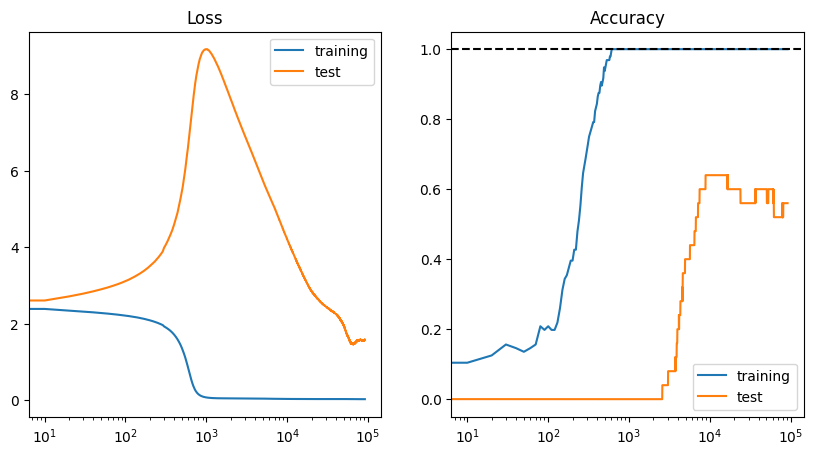

In [141]:
# Re-run this as many times as desired to continue training
train(4000, model, optimizer, data, logs)
logs.plot()